## Import Library

In [1]:
!pip install gdown

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gdown
import pickle
import math
import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score
from scipy import optimize
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
import time
from sklearn.model_selection import GridSearchCV

## Import Pre-processed Data

In [3]:
!mkdir -p content/data
# Download all files
file_ids = [
    '1fdbbwFuXm0zrXYi3i9MvCqilA9i7OcZq',  # X_train
    '1-1iUTztO9XpxwzF02JhoW3pdMs5jKrw1',  # X_train_resampled
    '1-39uqbcZldsGLgDKYfxIHsSNGewMXJRR',  # X_test
    '1Ms25aS5NADPDYdt8AGAUyYIjbdBvKGFZ',  # X_test_resampled
    '1-CChPe58Z6E-H6EXIzKsgUhqbITAd54z',  # Y_train
    '1D3wYlWZbt5NeM59QTA1JaVVvnaAZzFUf',  # Y_train_resampled
    '1-CUpVhcZ6-Qop7R9Z6Btb2gEf7f0XgGy'   # Y_test
]

file_paths = [
    'content/data/X_train.pkl',
    'content/data/X_train_resampled.pkl',
    'content/data/X_test.pkl',
    'content/data/X_test_resampled.pkl',
    'content/data/Y_train.pkl',
    'content/data/Y_train_resampled.pkl',
    'content/data/Y_test.pkl'
]
for file_id, file_path in zip(file_ids, file_paths):
    gdown.download(f'https://drive.google.com/uc?id={file_id}', file_path, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1fdbbwFuXm0zrXYi3i9MvCqilA9i7OcZq
To: /content/content/data/X_train.pkl
100%|██████████| 21.4M/21.4M [00:00<00:00, 97.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-1iUTztO9XpxwzF02JhoW3pdMs5jKrw1
To: /content/content/data/X_train_resampled.pkl
100%|██████████| 18.7M/18.7M [00:00<00:00, 78.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-39uqbcZldsGLgDKYfxIHsSNGewMXJRR
To: /content/content/data/X_test.pkl
100%|██████████| 5.35M/5.35M [00:00<00:00, 53.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Ms25aS5NADPDYdt8AGAUyYIjbdBvKGFZ
To: /content/content/data/X_test_resampled.pkl
100%|██████████| 5.35M/5.35M [00:00<00:00, 143MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-CChPe58Z6E-H6EXIzKsgUhqbITAd54z
To: /content/content/data/Y_train.pkl
100%|██████████| 2.79M/2.79M [00:00<00:00, 163MB/s]
Downloading...
From: https://drive.google.com/uc?id=1D3wYlWZbt5NeM59QTA1JaVVvnaAZzFUf
To: /content/

In [4]:
X_train = pd.read_pickle('content/data/X_train.pkl')
X_train_resampled = pd.read_pickle('content/data/X_train_resampled.pkl')
X_test = pd.read_pickle('content/data/X_test.pkl')
X_test_resampled = pd.read_pickle('content/data/X_test_resampled.pkl')
y_train = pd.read_pickle('content/data/Y_train.pkl')
y_train_resampled = pd.read_pickle('content/data/Y_train_resampled.pkl')
y_test = pd.read_pickle('content/data/Y_test.pkl')

In [5]:
result_acc=[]
result_recall=[]
pred_time = []

## 1. XGBoost - Thư viện (Không training với resampled data)

### 1.1 No Resampled

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:08:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:08:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:08:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:08:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:09:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

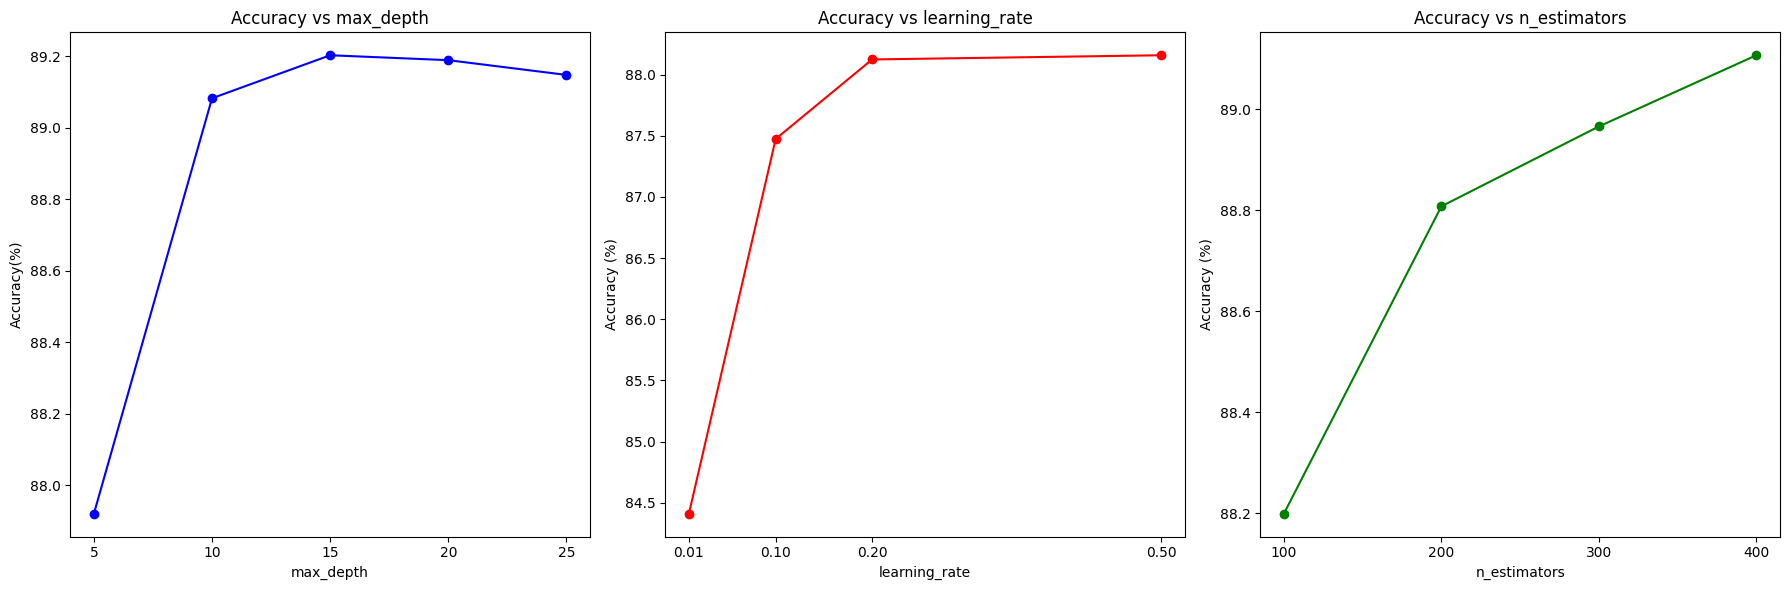

In [6]:
# Các giá trị siêu tham số để kiểm tra
param_grids = {
    'max_depth': [5, 10, 15, 20, 25],
    'learning_rate': [0.01, 0.1, 0.2, 0.5],
    'n_estimators': [100, 200, 300, 400]
}

# Lưu kết quả
results = {}

# Duyệt qua từng tham số
for param_name, param_values in param_grids.items():
    mean_accuracy = []
    for value in param_values:
        params = {'objective': 'binary:logistic', 'eval_metric': 'logloss'}
        params[param_name] = value

        # Huấn luyện mô hình
        model = xgb.XGBClassifier(**params, use_label_encoder=False)
        model.fit(X_train, y_train)

        # Dự đoán và tính accuracy
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)*100
        mean_accuracy.append(acc)

    results[param_name] = mean_accuracy

# Vẽ biểu đồ cho từng tham số
fig, ax = plt.subplots(1, 3, figsize=(18, 6))  # 3 biểu đồ trong 1 hàng

# Vẽ biểu đồ cho max_depth
ax[0].plot(param_grids['max_depth'], results['max_depth'], marker='o', color='b')
ax[0].set_xlabel('max_depth')
ax[0].set_ylabel('Accuracy(%)')
ax[0].set_title('Accuracy vs max_depth')
ax[0].set_xticks(param_grids['max_depth'])  # Đặt giá trị cho trục x

# Vẽ biểu đồ cho learning_rate
ax[1].plot(param_grids['learning_rate'], results['learning_rate'], marker='o', color='r')
ax[1].set_xlabel('learning_rate')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title('Accuracy vs learning_rate')
ax[1].set_xticks(param_grids['learning_rate'])

# Vẽ biểu đồ cho n_estimators
ax[2].plot(param_grids['n_estimators'], results['n_estimators'], marker='o', color='g')
ax[2].set_xlabel('n_estimators')
ax[2].set_ylabel('Accuracy (%)')
ax[2].set_title('Accuracy vs n_estimators')
ax[2].set_xticks(param_grids['n_estimators'])

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()


In [7]:
# Đưa dữ liệu vào DMatrix (DMatrix là một cấu trúc dữ liệu đặc biệt của XGBoost)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Cài đặt tham số của mô hình XGBoost
params = {
    'objective': 'binary:logistic',   # Đối với bài toán phân loại nhị phân
    'eval_metric': 'logloss',          # Đánh giá dựa trên log loss
    'max_depth': 15,                    # Độ sâu của cây
    'eta': 0.2,                        # Learning rate
    'subsample': 1,                  # Tỉ lệ mẫu ngẫu nhiên cho mỗi cây
    'colsample_bytree': 1,           # Tỉ lệ đặc trưng được sử dụng cho mỗi cây
    'nthread': 4                       # Số lượng luồng xử lý song song
}

# Đặt số vòng lặp (n_estimators)
num_round = 400
# Huấn luyện mô hình XGBoost
xgb_model = xgb.train(params, dtrain, num_round)

# Dự đoán trên tập Test
start_time = time.time()
y_pred = xgb_model.predict(dtest)
end_time = time.time()
predict_time=end_time-start_time
pred_time.append(predict_time)
print(f"Time to predict: {predict_time:.4f} seconds")

y_pred_binary = (y_pred > 0.5).astype(int)
acc= accuracy_score(y_test, y_pred_binary)*100
result_acc.append(acc)
print("Test Accuracy {:.2f}%".format(acc))

Time to predict: 0.9476 seconds
Test Accuracy 89.73%


In [8]:
print(classification_report(y_test, y_pred_binary))

              precision    recall  f1-score   support

         0.0       0.91      0.96      0.94     22571
         1.0       0.82      0.69      0.75      6521

    accuracy                           0.90     29092
   macro avg       0.87      0.82      0.84     29092
weighted avg       0.89      0.90      0.89     29092



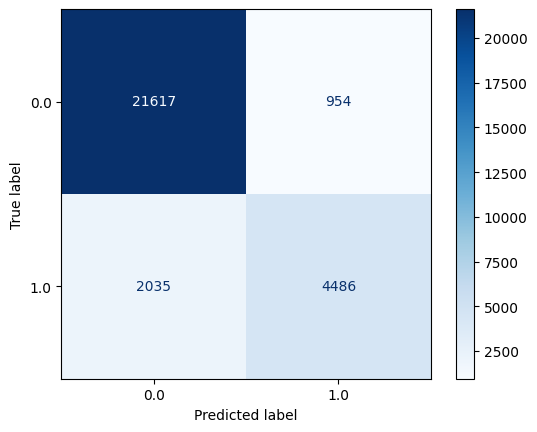

<Figure size 1200x1200 with 0 Axes>

In [9]:
cm = confusion_matrix(y_test, y_pred_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap='Blues', values_format='d')
plt.figure(figsize=(12, 12))
plt.show()

In [10]:
recall_s = recall_score(y_test, y_pred_binary, average=None)
print('Tỉ lệ dự đoán đúng ngày mai có mưa là', recall_s[1])
print('Tỉ lệ dự đoán đúng ngày mai không có mưa là', recall_s[0])
result_recall.append(recall_s)

Tỉ lệ dự đoán đúng ngày mai có mưa là 0.6879312988805398
Tỉ lệ dự đoán đúng ngày mai không có mưa là 0.9577333746843294


### 1.2 Resampled

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:10:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:10:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:10:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:10:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:10:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

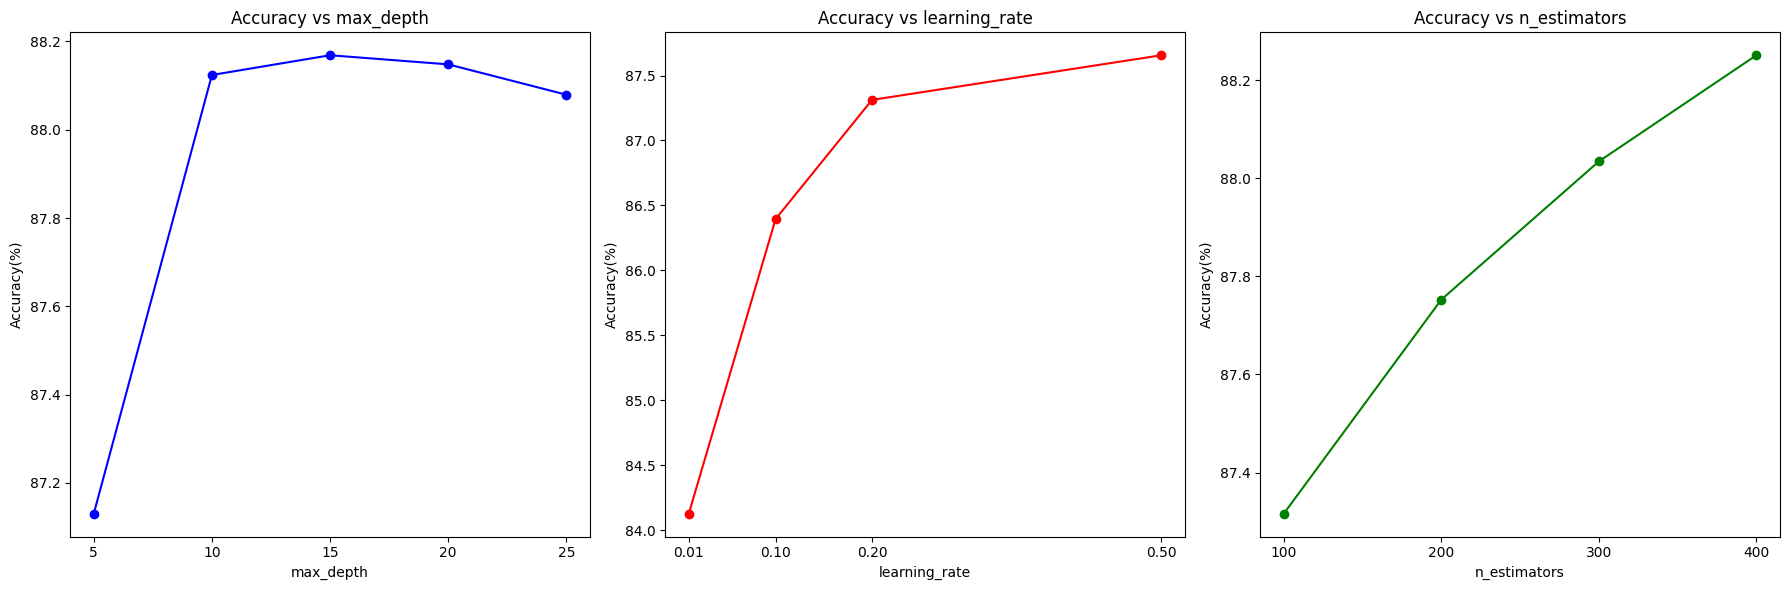

In [11]:
# Các giá trị siêu tham số để kiểm tra
param_grids = {
    'max_depth': [5, 10, 15, 20, 25],
    'learning_rate': [0.01, 0.1, 0.2, 0.5],
    'n_estimators': [100, 200, 300, 400]
}

# Lưu kết quả
results = {}

# Duyệt qua từng tham số
for param_name, param_values in param_grids.items():
    mean_accuracy = []
    for value in param_values:
        params = {'objective': 'binary:logistic', 'eval_metric': 'logloss'}
        params[param_name] = value

        # Huấn luyện mô hình
        model = xgb.XGBClassifier(**params, use_label_encoder=False)
        model.fit(X_train_resampled, y_train_resampled)

        # Dự đoán và tính accuracy
        y_pred = model.predict(X_test_resampled)
        acc = accuracy_score(y_test, y_pred)*100
        mean_accuracy.append(acc)

    results[param_name] = mean_accuracy

# Vẽ biểu đồ cho từng tham số
fig, ax = plt.subplots(1, 3, figsize=(18, 6))  # 3 biểu đồ trong 1 hàng

# Vẽ biểu đồ cho max_depth
ax[0].plot(param_grids['max_depth'], results['max_depth'], marker='o', color='b')
ax[0].set_xlabel('max_depth')
ax[0].set_ylabel('Accuracy(%)')
ax[0].set_title('Accuracy vs max_depth')
ax[0].set_xticks(param_grids['max_depth'])  # Đặt giá trị cho trục x

# Vẽ biểu đồ cho learning_rate
ax[1].plot(param_grids['learning_rate'], results['learning_rate'], marker='o', color='r')
ax[1].set_xlabel('learning_rate')
ax[1].set_ylabel('Accuracy(%)')
ax[1].set_title('Accuracy vs learning_rate')
ax[1].set_xticks(param_grids['learning_rate'])

# Vẽ biểu đồ cho n_estimators
ax[2].plot(param_grids['n_estimators'], results['n_estimators'], marker='o', color='g')
ax[2].set_xlabel('n_estimators')
ax[2].set_ylabel('Accuracy(%)')
ax[2].set_title('Accuracy vs n_estimators')
ax[2].set_xticks(param_grids['n_estimators'])

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()


In [12]:
# Đưa dữ liệu vào DMatrix (DMatrix là một cấu trúc dữ liệu đặc biệt của XGBoost)
dtrain_res = xgb.DMatrix(X_train_resampled, label=y_train_resampled)
dtest = xgb.DMatrix(X_test_resampled, label=y_test)

# Cài đặt tham số của mô hình XGBoost
params = {
    'objective': 'binary:logistic',   # Đối với bài toán phân loại nhị phân
    'eval_metric': 'logloss',          # Đánh giá dựa trên log loss
    'max_depth': 15,                    # Độ sâu của cây
    'eta': 0.5,                        # Learning rate
    'subsample': 1,                  # Tỉ lệ mẫu ngẫu nhiên cho mỗi cây
    'colsample_bytree': 1,           # Tỉ lệ đặc trưng được sử dụng cho mỗi cây
    'nthread': 4                       # Số lượng luồng xử lý song song
}

# Đặt số vòng lặp (n_estimators)
num_round = 400
# Huấn luyện mô hình XGBoost
xgb_res_model = xgb.train(params, dtrain_res, num_round)

# Dự đoán trên tập Test
start_time = time.time()
y_pred_res = xgb_res_model.predict(dtest)
end_time = time.time()
predict_time=end_time-start_time
pred_time.append(predict_time)
print(f"Time to predict: {predict_time:.4f} seconds")

y_pred_res_binary = (y_pred_res > 0.5).astype(int)
acc= accuracy_score(y_test, y_pred_res_binary)*100
result_acc.append(acc)
print("Test Accuracy {:.2f}%".format(acc))

Time to predict: 0.9979 seconds
Test Accuracy 88.55%


In [13]:
print(classification_report(y_test, y_pred_res_binary))

              precision    recall  f1-score   support

         0.0       0.93      0.92      0.93     22571
         1.0       0.73      0.77      0.75      6521

    accuracy                           0.89     29092
   macro avg       0.83      0.85      0.84     29092
weighted avg       0.89      0.89      0.89     29092



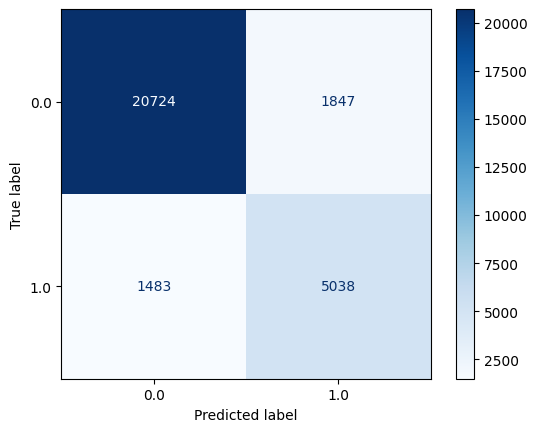

<Figure size 1200x1200 with 0 Axes>

In [14]:
cm = confusion_matrix(y_test, y_pred_res_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap='Blues', values_format='d')
plt.figure(figsize=(12, 12))
plt.show()

In [15]:
recall_s = recall_score(y_test, y_pred_res_binary, average=None)
print('Tỉ lệ dự đoán đúng ngày mai có mưa là', recall_s[1])
print('Tỉ lệ dự đoán đúng ngày mai không có mưa là', recall_s[0])
result_recall.append(recall_s)

Tỉ lệ dự đoán đúng ngày mai có mưa là 0.7725808925011501
Tỉ lệ dự đoán đúng ngày mai không có mưa là 0.9181693323290948


## 2. XGBoost - Tự code

### No Resampled

In [16]:
# Khởi tạo mô hình yếu (cây quyết định)
def weak_model(X, y, sample_weight=None):
    model = DecisionTreeClassifier(max_depth=10)
    model.fit(X, y, sample_weight=sample_weight)
    return model
def log_loss(y_true, y_pred, epsilon=1e-15):
    # Đảm bảo rằng các giá trị dự đoán không quá nhỏ hoặc quá lớn
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    # Tính log loss
    loss = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    return loss


In [18]:
n_estimators = 400
learning_rate = 0.2
# Ban đầu, dự đoán của mô hình là 0 (hoặc có thể là trung bình nếu là hồi quy)
y_pred_train = np.zeros_like(y_train, dtype=float)
models = []
sample_weights = np.ones_like(y_train, dtype=float)
# Quá trình huấn luyện
for i in range(n_estimators):
    # Huấn luyện mô hình yếu (cây quyết định tự code)
    model = weak_model(X_train, y_train, sample_weight=sample_weights)
    models.append(model)
    # Dự đoán từ mô hình hiện tại (thực hiện xác suất, nếu có thể)
    y_pred_train_model = model.predict(X_train)
    # Tính toán log loss và cập nhật trọng số
    log_loss_value = log_loss(y_train, y_pred_train_model)
    error = y_pred_train_model != y_train
    sample_weights = sample_weights * np.exp(learning_rate * log_loss_value)  # Cập nhật trọng số theo log loss
    # Tránh giá trị vô hạn hoặc quá lớn
    sample_weights = np.clip(sample_weights, a_min=1e-10, a_max=1e10)
    # Chuẩn hóa trọng số để tổng = 1
    sample_weights /= np.sum(sample_weights)
    # Cập nhật dự đoán cuối cùng (cập nhật theo xác suất thay vì dự đoán nhị phân)
    y_pred_train += learning_rate * (y_pred_train_model * 2 - 1)  # Chuyển đổi dự đoán thành {1, -1}
# Khởi tạo y_pred_test với kích thước đúng
y_pred_test = np.zeros(X_test.shape[0], dtype=float)

# Dự đoán trên tập Test
start_time = time.time()
for model in models:
    y_pred_test += learning_rate * (model.predict(X_test) * 2 - 1)  # Chuyển đổi dự đoán thành {1, -1}
end_time = time.time()
predict_time=end_time-start_time
pred_time.append(predict_time)
print(f"Time to predict: {predict_time:.4f} seconds")

# Chuyển đổi dự đoán về dạng xác suất [0, 1]
y_pred_test_prob = (y_pred_test * 2 - 1) * 0.5 + 0.5
# Chuyển dự đoán về dạng {0, 1}
y_pred_test_binary = (y_pred_test_prob > 0.5).astype(int)
# Đánh giá mô hình
acc = accuracy_score(y_test, y_pred_test_binary) * 100
result_acc.append(acc)
print("Test Accuracy: {:.2f}%".format(acc))

Time to predict: 3.4827 seconds
Test Accuracy: 85.17%


In [19]:
print(classification_report(y_test, y_pred_test_binary))

              precision    recall  f1-score   support

         0.0       0.88      0.93      0.91     22571
         1.0       0.71      0.57      0.63      6521

    accuracy                           0.85     29092
   macro avg       0.80      0.75      0.77     29092
weighted avg       0.84      0.85      0.85     29092



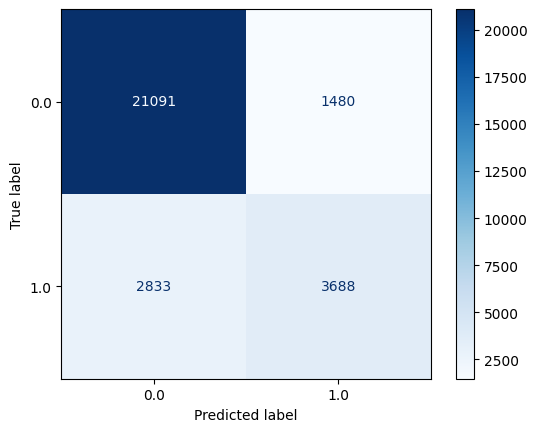

<Figure size 1200x1200 with 0 Axes>

In [20]:
cm = confusion_matrix(y_test, y_pred_test_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap='Blues', values_format='d')
plt.figure(figsize=(12, 12))
plt.show()

In [21]:
recall_s = recall_score(y_test, y_pred_test_binary, average=None)
print('Tỉ lệ dự đoán đúng ngày mai có mưa là', recall_s[1])
print('Tỉ lệ dự đoán đúng ngày mai không có mưa là', recall_s[0])
result_recall.append(recall_s)

Tỉ lệ dự đoán đúng ngày mai có mưa là 0.5655574298420488
Tỉ lệ dự đoán đúng ngày mai không có mưa là 0.9344291347304062


### Resampled

In [22]:
n_estimators = 400
learning_rate = 0.5
# Ban đầu, dự đoán của mô hình là 0 (hoặc có thể là trung bình nếu là hồi quy)
y_pred_train_res = np.zeros_like(y_train_resampled, dtype=float)
models_res = []
sample_weights_res = np.ones_like(y_train_resampled, dtype=float)
# Quá trình huấn luyện
for i in range(n_estimators):
    # Huấn luyện mô hình yếu (cây quyết định tự code)
    model = weak_model(X_train_resampled, y_train_resampled, sample_weight=sample_weights_res)
    models_res.append(model)
    # Dự đoán từ mô hình hiện tại (thực hiện xác suất, nếu có thể)
    y_pred_train_res = model.predict(X_train_resampled)
    # Tính toán log loss và cập nhật trọng số
    log_loss_value = log_loss(y_train_resampled, y_pred_train_res)
    error = y_pred_train_res != y_train_resampled
    sample_weights_res = sample_weights_res * np.exp(learning_rate * log_loss_value)  # Cập nhật trọng số theo log loss
    sample_weights_res = np.clip(sample_weights_res, a_min=1e-10, a_max=1e10)
    sample_weights_res /= np.sum(sample_weights_res)
    # Cập nhật dự đoán cuối cùng (cập nhật theo xác suất thay vì dự đoán nhị phân)
    y_pred_train_res += learning_rate * (y_pred_train_res * 2 - 1)  # Chuyển đổi dự đoán thành {1, -1}
# Khởi tạo y_pred_test với kích thước đúng
y_pred_test = np.zeros(X_test_resampled.shape[0], dtype=float)

# Dự đoán trên tập Test
start_time = time.time()
for model in models_res:
    y_pred_test += learning_rate * (model.predict(X_test_resampled) * 2 - 1)  # Chuyển đổi dự đoán thành {1, -1}
end_time = time.time()
predict_time=end_time-start_time
pred_time.append(predict_time)
print(f"Time to predict: {predict_time:.4f} seconds")

# Chuyển đổi dự đoán về dạng xác suất [0, 1] (nếu cần thiết)
y_pred_test_prob = (y_pred_test * 2 - 1) * 0.5 + 0.5
# Chuyển dự đoán về dạng {0, 1}
y_pred_test_binary = (y_pred_test_prob > 0.5).astype(int)
# Đánh giá mô hình
acc = accuracy_score(y_test, y_pred_test_binary) * 100
result_acc.append(acc)
print("Test Accuracy: {:.2f}%".format(acc))

Time to predict: 3.6197 seconds
Test Accuracy: 82.18%


In [23]:
print(classification_report(y_test, y_pred_test_binary))

              precision    recall  f1-score   support

         0.0       0.91      0.85      0.88     22571
         1.0       0.58      0.72      0.65      6521

    accuracy                           0.82     29092
   macro avg       0.75      0.79      0.76     29092
weighted avg       0.84      0.82      0.83     29092



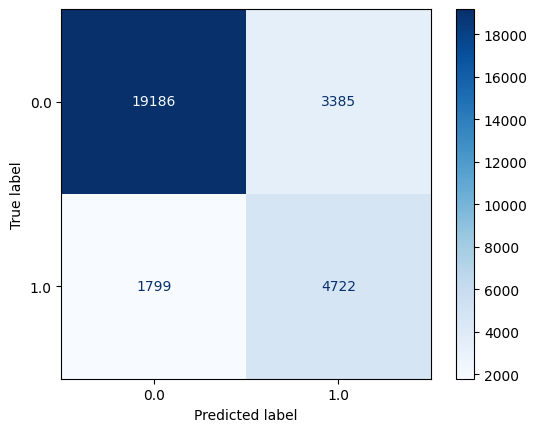

<Figure size 1200x1200 with 0 Axes>

In [24]:
cm = confusion_matrix(y_test, y_pred_test_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap='Blues', values_format='d')
plt.figure(figsize=(12, 12))
plt.show()

In [25]:
recall_s = recall_score(y_test, y_pred_test_binary, average=None)
print('Tỉ lệ dự đoán đúng ngày mai có mưa là', recall_s[1])
print('Tỉ lệ dự đoán đúng ngày mai không có mưa là', recall_s[0])
result_recall.append(recall_s)

Tỉ lệ dự đoán đúng ngày mai có mưa là 0.7241220671676123
Tỉ lệ dự đoán đúng ngày mai không có mưa là 0.8500287980151522


## 3. Model Comparing

In [26]:
result_acc

[89.72569778633301, 88.55355424171594, 85.17461845180806, 82.18066822494157]

In [27]:
result_recall

[array([0.95773337, 0.6879313 ]),
 array([0.91816933, 0.77258089]),
 array([0.93442913, 0.56555743]),
 array([0.8500288 , 0.72412207])]

In [28]:
pred_time

[0.9476358890533447, 0.9978713989257812, 3.482661008834839, 3.6196601390838623]

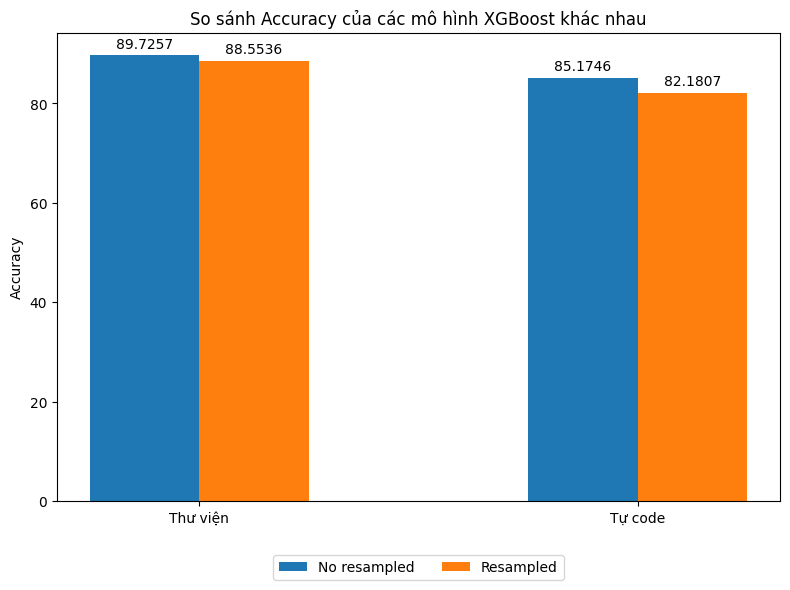

In [29]:
labels = ['Thư viện', 'Tự code']
no_res = [result_acc[0], result_acc[2]]
res = [result_acc[1], result_acc[3]]

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, no_res, width, label='No resampled')
rects2 = ax.bar(x + width/2, res, width, label='Resampled')

# Add some text for labels, title and custom y-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('So sánh Accuracy của các mô hình XGBoost khác nhau')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

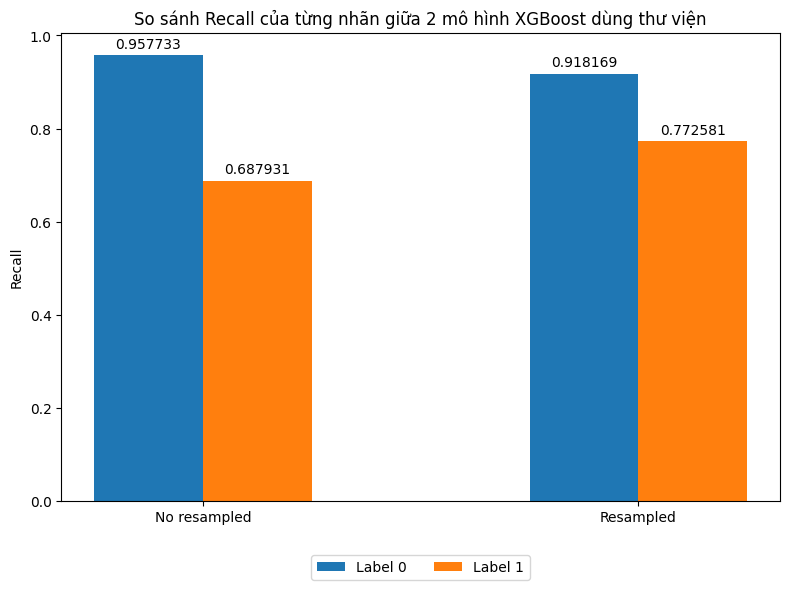

In [30]:
labels = ['No resampled', 'Resampled']
label_0 = [result_recall[0][0], result_recall[1][0]]
label_1 = [result_recall[0][1], result_recall[1][1]]

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, label_0, width, label='Label 0')
rects2 = ax.bar(x + width/2, label_1, width, label='Label 1')

# Add some text for labels, title and custom y-axis tick labels, etc.
ax.set_ylabel('Recall')
ax.set_title('So sánh Recall của từng nhãn giữa 2 mô hình XGBoost dùng thư viện')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

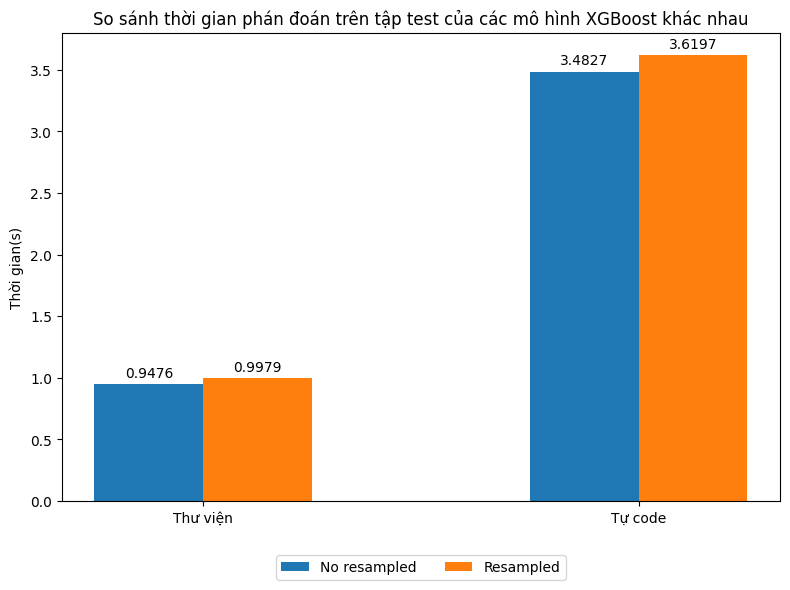

In [31]:
labels = ['Thư viện', 'Tự code']
no_res = [pred_time[0], pred_time[2]]
res = [pred_time[1], pred_time[3]]

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, no_res, width, label='No resampled')
rects2 = ax.bar(x + width/2, res, width, label='Resampled')

# Add some text for labels, title and custom y-axis tick labels, etc.
ax.set_ylabel('Thời gian(s)')
ax.set_title('So sánh thời gian phán đoán trên tập test của các mô hình XGBoost khác nhau')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

ax.bar_label(rects1, padding=3, labels=[f"{value:.4f}" for value in no_res])
ax.bar_label(rects2, padding=3, labels=[f"{value:.4f}" for value in res])

fig.tight_layout()

plt.show()

In [33]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/Result/Model_Evaluation/6. XGBoost.pkl'
with open(file_path, 'wb') as f:
    pickle.dump([result_acc,result_recall,pred_time],f)

Mounted at /content/drive
